This code is copied from the following link:
https://github.com/safwankdb/Vanilla-GAN/blob/master/Vanilla_GAN.ipynb

The code used to output the generated data is inspired by the following code: https://github.com/togheppi/vanilla_GAN/blob/master/MNIST_GAN_pytorch.py

Convolutional edits refer to: https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd.variable import Variable
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import imageio
import torch.nn.functional as F
import numpy as np

### Read in data

In [2]:
transform = transforms.Compose([       # Make sure to change the parameters accordingly
                transforms.ToTensor(),
                transforms.Normalize((0.5,),(0.5,))
                ])
to_image = transforms.ToPILImage()
trainset = MNIST(root='./data/', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=100, shuffle=True)  # This draws the data from MNIST

device = 'cpu'

## Generator and Discriminator Networks

In [4]:
class Generator(nn.Module):   # All images are 28x28 (784=28^2)
    def __init__(self):
        super(Generator, self).__init__()
        self.n_features = 128
        self.n_out = 784  # (28x28)
        self.fc0 = nn.Sequential(
                    nn.Linear(self.n_features, 256),
                    nn.LeakyReLU(0.2)
                    )
        self.fc1 = nn.Sequential(
                    nn.Linear(256, 512),
                    nn.LeakyReLU(0.2)
                    )
        self.fc2 = nn.Sequential(
                    nn.Linear(512, 1024),
                    nn.LeakyReLU(0.2)
                    )
        self.fc3 = nn.Sequential(
                    nn.Linear(1024, self.n_out),
                    nn.Tanh()
                    )
    def forward(self, x):
        x = self.fc0(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = x.view(-1, 1, 28, 28)
        return x

In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.n_in = 400   # It's 400 for some reason ¯\_(ツ)_/¯
        self.n_out = 1
        
        self.conv1 = nn.Conv2d(1, 6, 3)  # Convolution layers
        self.conv2 = nn.Conv2d(6, 16, 3)
        
        self.fc0 = nn.Sequential(
                    nn.Linear(self.n_in, 1024),
                    nn.LeakyReLU(0.2),
                    nn.Dropout(0.3)
                    )
        self.fc1 = nn.Sequential(
                    nn.Linear(1024, 512),
                    nn.LeakyReLU(0.2),
                    nn.Dropout(0.3)
                    )
        self.fc2 = nn.Sequential(
                    nn.Linear(512, 256),
                    nn.LeakyReLU(0.2),
                    nn.Dropout(0.3)
                    )
        self.fc3 = nn.Sequential(
                    nn.Linear(256, self.n_out),
                    nn.Sigmoid()
                    )
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))  # Applies convolution layers and pools them together
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        #x = x.view(-1, 784)
        x = self.fc0(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

### Training methods

In [6]:
def train_discriminator(optimizer, real_data, fake_data):
    n = real_data.size(0)

    optimizer.zero_grad()
    
    prediction_real = discriminator(real_data)
    error_real = criterion(prediction_real, make_ones(n))
    error_real.backward()

    prediction_fake = discriminator(fake_data)
    error_fake = criterion(prediction_fake, make_zeros(n))
    
    error_fake.backward()
    optimizer.step()
    
    return error_real + error_fake

In [7]:
def train_generator(optimizer, fake_data):
    n = fake_data.size(0)
    optimizer.zero_grad()
    
    prediction = discriminator(fake_data)
    error = criterion(prediction, make_ones(n))
    
    error.backward()
    optimizer.step()
    
    return error

## Main Methods

In [8]:
generator = Generator()
discriminator = Discriminator()

generator.to(device)
discriminator.to(device)

g_optim = optim.Adam(generator.parameters(), lr=2e-4)
d_optim = optim.Adam(discriminator.parameters(), lr=2e-4)

g_losses = []
d_losses = []
images = []

criterion = nn.BCELoss()

def noise(n, n_features=128):
    return Variable(torch.randn(n, n_features)).to(device)

def make_ones(size):
    data = Variable(torch.ones(size, 1))
    return data.to(device)

def make_zeros(size):
    data = Variable(torch.zeros(size, 1))
    return data.to(device)

In [9]:
num_epochs = 25
k = 1
test_noise = noise(64)

generator.train()
discriminator.train()
for epoch in range(num_epochs):
    g_error = 0.0
    d_error = 0.0
    for i, data in enumerate(trainloader):
        imgs, _ = data
        n = len(imgs)
        for j in range(k):
            fake_data = generator(noise(n)).detach()
            real_data = imgs.to(device)
            d_error += train_discriminator(d_optim, real_data, fake_data)
        fake_data = generator(noise(n))
        g_error += train_generator(g_optim, fake_data)

    img = generator(test_noise).cpu().detach()
    img = make_grid(img)
    images.append(img)
    g_losses.append(g_error/i)
    d_losses.append(d_error/i)
    print('Epoch {}: g_loss: {:.8f} d_loss: {:.8f}\r'.format(epoch, g_error/i, d_error/i))
    
print('Training Finished')
torch.save(generator.state_dict(), 'mnist_generator.pth')

Epoch 0: g_loss: 3.00442576 d_loss: 0.59660035
Epoch 1: g_loss: 3.75065613 d_loss: 0.34094191
Epoch 2: g_loss: 3.72999668 d_loss: 0.26756582
Epoch 3: g_loss: 4.49789476 d_loss: 0.24163376
Epoch 4: g_loss: 3.71087217 d_loss: 0.25176933
Epoch 5: g_loss: 4.22865868 d_loss: 0.31200501
Epoch 6: g_loss: 4.49752283 d_loss: 0.16905297
Epoch 7: g_loss: 5.18294716 d_loss: 0.11035285
Epoch 8: g_loss: 5.34365177 d_loss: 0.13368572
Epoch 9: g_loss: 4.29963779 d_loss: 0.16873270
Epoch 10: g_loss: 4.44878197 d_loss: 0.16033415
Epoch 11: g_loss: 4.78625202 d_loss: 0.17616554
Epoch 12: g_loss: 4.16700745 d_loss: 0.19641252
Epoch 13: g_loss: 3.91310549 d_loss: 0.21553245
Epoch 14: g_loss: 4.01563501 d_loss: 0.21534263
Epoch 15: g_loss: 3.68492293 d_loss: 0.24554260
Epoch 16: g_loss: 3.16802716 d_loss: 0.31718507
Epoch 17: g_loss: 3.41346049 d_loss: 0.28098366
Epoch 18: g_loss: 3.17048049 d_loss: 0.32952794
Epoch 19: g_loss: 3.01859951 d_loss: 0.34256431
Epoch 20: g_loss: 2.97195125 d_loss: 0.34988812
Ep

### Graphing results

In [10]:
import numpy as np
from matplotlib import pyplot as plt
imgs = [np.array(to_image(i)) for i in images]
imageio.mimsave('progress.gif', imgs)

In [11]:
image_size = 28

def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

def plot_result(generator, noise, num_epoch, save=False, save_dir='MNIST_GAN_results/', show=False, fig_size=(5, 5)):
    generator.eval()

    noise = Variable(noise.cpu())
    gen_image = generator(noise)
    gen_image = denorm(gen_image)

    generator.train()

    n_rows = np.sqrt(noise.size()[0]).astype(np.int32)
    n_cols = np.sqrt(noise.size()[0]).astype(np.int32)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=fig_size)
    for ax, img in zip(axes.flatten(), gen_image):
        ax.axis('off')
        ax.set_adjustable('box-forced')
        ax.imshow(img.cpu().data.view(image_size, image_size).numpy(), cmap='gray', aspect='equal')
    plt.subplots_adjust(wspace=0, hspace=0)
    title = 'Epoch {0}'.format(num_epoch+1)
    fig.text(0.5, 0.04, title, ha='center')

    # save figure
    if save:
        if not os.path.exists(save_dir):
            os.mkdir(save_dir)
        save_fn = save_dir + 'MNIST_GAN_epoch_{:d}'.format(num_epoch+1) + '.png'
        plt.savefig(save_fn)

    if show:
        plt.show()
    else:
        plt.close()

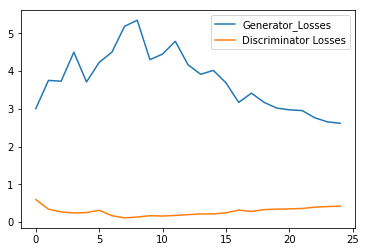

In [12]:
plt.plot(g_losses, label='Generator_Losses')
plt.plot(d_losses, label='Discriminator Losses')
plt.legend()
plt.savefig('loss.png')

C:\Users\jcbre\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:1334: MatplotlibDeprecationWarning: 
box-forced
  "2.2", "box-forced", obj_type="keyword argument")


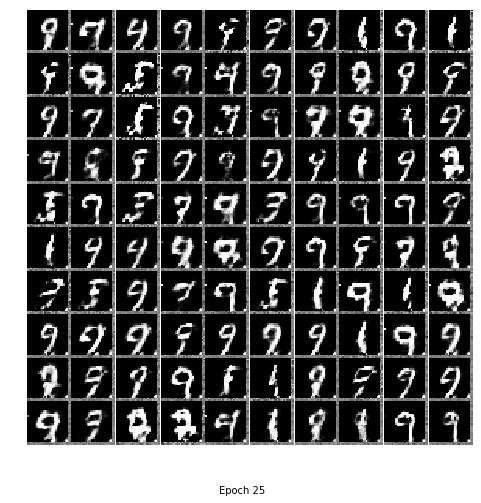

In [13]:
fixed_noise = torch.randn(n, 128)
plot_result(generator, fixed_noise, epoch, show=True, fig_size=(8, 8))